In [5]:
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
# tqdm.pandas(desc="pandas profile bar")

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', 35)

%matplotlib inline

# Загрузка данных пользователей

In [6]:
def load_train_set (path_to_csv_files):
    ''' return DataFrame of loaded .csv files from path'''
    allfiles = sorted(glob(os.path.join(path_to_csv_files,'*.csv')))
    sessions = []
    for file in allfiles: 
        user_sessions = []
        user_id = file [-8:-4]
        with open(file, 'r') as filereader:   
            for row in filereader.readlines()[1:]: #пропускаем заголовок
                line = row.strip().split(',') + [user_id]
                user_sessions.append (line)
        sessions.extend (user_sessions)
    
    df = pd.DataFrame (sessions, columns = ['time_start', 'site', 'user_id'])
    df.time_start = df.time_start.astype('datetime64')
    return df

# I. Feature Engineering

Реализуем функцию, выполняющую следующие операции:
1. Выполним деление на сессии методом скользящего окна по обоим доступным признакам -время сессии и сайт.
2. Создадим новый df из сессий.
3. Генерируем новые признаки по доступным.
Все делается средствами pandas. 

In [7]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' return new df with engineered features  '''
    
    #загрузка файлов в df для последующей обработки
    df = load_train_set(path_to_csv_files)
    
    # замена имен сайтов на id из частотного словаря
    with open (site_freq_path, 'rb') as f:
        dict_ = pickle.load(f)
    dict_[0]= (0,0)
    df.site = df.site.apply(lambda x: dict_[x][0])
    
    # генерация сессий скользящими окнами по сайту и времени его посещения
    site_frame_ = [] #список фреймов сайтов
    time_frame_ = [] #список фреймов таймштампов
    time_diff_ = [] # список фреймов разности соседних таймштампов
    target = []

    for user in tqdm (df.user_id.unique()):
        site_log = df[df['user_id']== user].site
        site_frame_.append (pd.DataFrame ([site_log[sp:sp+session_length].values for sp in range(0,site_log.shape[0],window_size)]))
    
        time_log = df[df['user_id']== user].time_start
        t = pd.DataFrame ([time_log[sp:sp+session_length].values for sp in range(0,time_log.shape[0],window_size)])
    
        time_frame_.append (t) 
        time_diff_.append((t - t.shift(axis=1)).applymap(lambda x: x.seconds).fillna(0).astype(int).drop(columns = [0])) # 
    
        target.extend ([user]*t.shape[0]) #восстановим столбец разметки для  размерности нового df
    
    # создание новых fe
    site_frame = (pd.concat(site_frame_, ignore_index=True)).fillna(0).astype(int)
    time_frame = (pd.concat(time_frame_, ignore_index=True))
    time_diff = (pd.concat(time_diff_, ignore_index=True)).fillna(0).astype(int)
    
    new_df = pd.concat((site_frame,time_diff), axis = 1)
    new_df['session_timespan'] = time_frame.apply(lambda x: (x.max() - x.min()).total_seconds(), axis = 1).astype(int)
    new_df['#unique_sites'] = site_frame[site_frame > 0].progress_apply(lambda x: x.dropna().unique().shape[0], axis = 1).astype(int) #быстрее, чем условие [x>0]
    new_df['start_hour'] = time_frame.apply(lambda x: x.min().hour, axis = 1).astype(int)
    new_df['day_of_week'] = time_frame.apply(lambda x: x.min().weekday(), axis = 1).astype(int)
    new_df['target']=pd.DataFrame(target).astype (int)
    new_df.columns = feature_names
    return new_df

## Обработка исходных данных

### "Игрушечный" фрейм

In [8]:
##%%time
PATH_TO_DATA = r'C:\Users\Дмитрий Мошкин\Documents\GitHub\moshkin\MFTI_Yandex_DA_specialisation\6 course\capstone_user_identification'
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

AttributeError: 'DataFrame' object has no attribute 'progress_apply'

In [265]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      3      2      2      7      2      1      8      5      9      10   
1      3      1      1      1      0      0      0      0      0       0   
2      3      2      6      6      2      0      0      0      0       0   
3      4      1      2      1      2      1      1      5     11       4   
4      4      1      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

### Фрейм 10 пользователей

In [266]:
train_data_10users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [267]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    574    133      3    133    133      3    133    203     133   
1    415    193    674    254    133     31    393   3305    217      55   
2     55      3     55     55      5    293    415    333    897      55   
3    473   3306    473     55     55     55     55    937    199     123   
4    342     55      5   3307    258    211   3308   2086    675    2086   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week  target  
0           8            4      31  
1           8            4      31  
2           8            4      31  
3           8            4      31  
4           8            4      31

### Фрейм 150 пользователей

In [7]:
##%%time
train_data_150users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

In [8]:
train_data_150users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      1      4      2      1      4      1      2   1290     321   
1      2     23   1505   1290    321    321    113     73     49      49   
2    321    205      1      1      1      1     73    321      2       1   
3      1      1   6998   6998   5491   6998   6998      1     35       1   
4      1      1     76      1     58     50     58     50     83      76   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0           1           1           1           4           0           1   
1           0           0          26           1          10          73   
2           1          10           1           5          16          56   
3           1           0           1           0         118         420   
4           4           3           0           1           0           1   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0          49           0                57              5   
1           0        1504           4              1618              8   
2        1917           0           4              2010              5   
3        1460           6           0              2006              4   
4           0           1           0                10              5   

   start_hour  day_of_week  target  
0           8            4       6  
1           8            4       6  
2           8            4       6  
3           9            4       6  
4           9            4       6

Сохраним новые признаки в файл. 

In [268]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [13]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Медианы новых признаков

Вопрос 1: Выведите медианную продолжительность сессии (session_timespan) для сессий 10 пользователей.

In [269]:
print ('Медианная продолжительность сессии по данным 10 пользователей:  {}'.format(train_data_10users.session_timespan.median()))

Медианная продолжительность сессии по данным 10 пользователей:  37.0


Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.

In [270]:
print ('Медианный день недели, в который началась сессия, по данным 10 пользователей:  {}'.format(train_data_10users.day_of_week.median()))

Медианный день недели, в который началась сессия, по данным 10 пользователей:  2.0


Вопрос 3. Выведите медианный час начала сессии для сессий 150 пользователей.

In [12]:
print ('Медианный час, в который началась сессия, по данным 150 пользователей:  {}'.format(train_data_150users.start_hour.median()))

Медианный час, в который началась сессия, по данным 150 пользователей:  13.0


Вопрос 4. Выведите медианное значение числа уникальных сайтов для сессий 150 пользователей.

In [13]:
print ('Медианное значение числа уникальных сайтов в сессии по данным 150 пользователей:  {}'.format(train_data_150users['#unique_sites'].median()))

Медианное значение числа уникальных сайтов в сессии по данным 150 пользователей:  7.0


In [271]:
train_data_10users[new_features].describe()

session_timespan  #unique_sites    start_hour   day_of_week
count      1.406100e+04   14061.000000  14061.000000  14061.000000
mean       8.369030e+03       5.951355     13.768366      2.655714
std        9.603023e+04       2.362833      3.681279      1.793863
min        0.000000e+00       1.000000      7.000000      0.000000
25%        9.000000e+00       4.000000     11.000000      1.000000
50%        3.700000e+01       6.000000     14.000000      2.000000
75%        1.180000e+02       8.000000     16.000000      4.000000
max        6.595012e+06      10.000000     23.000000      6.000000

In [15]:
train_data_150users[new_features].describe()

session_timespan  #unique_sites     start_hour    day_of_week
count      1.370190e+05  137019.000000  137019.000000  137019.000000
mean       1.248841e+04       6.313154      12.839373       1.967005
std        1.374259e+05       2.262066       3.288743       1.496798
min        0.000000e+00       1.000000       7.000000       0.000000
25%        6.000000e+00       5.000000      10.000000       1.000000
50%        2.600000e+01       7.000000      13.000000       2.000000
75%        1.150000e+02       8.000000      15.000000       3.000000
max        9.404616e+06      10.000000      23.000000       6.000000

Медианные значения наборов данных для 10 и 150 пользователей близки. 

# II. Визуальный анализ

### Попарная сетка

In [272]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [273]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [274]:
fig, ax = plt.subplots(figsize = (8,5))
train_data_10users.target.value_counts().plot(kind = 'barh', ax = ax)
ax.set_title('Распределение записей по классам')

Text(0.5, 1.0, 'Распределение записей по классам')

Классы не сбалансированы. Построим попарную сетку, чтобы оценить возможные взаимозависимости признаков.

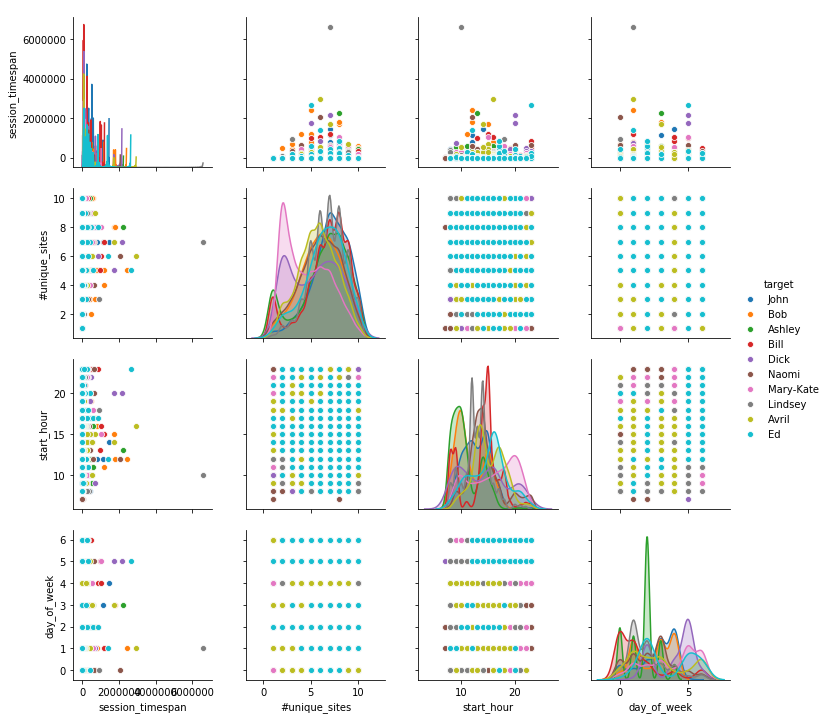

In [275]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
sns.pairplot (train_data_10users[new_features + ['target']], diag_kind = 'kde', hue = 'target')

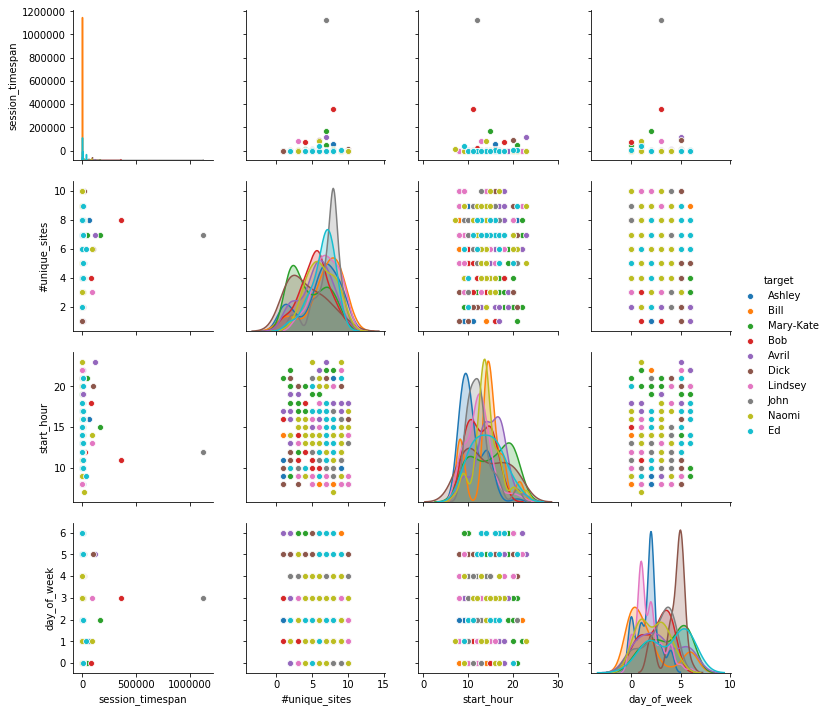

In [276]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
sns.pairplot (train_data_10users[new_features + ['target']].sample(500), diag_kind = 'kde', hue = 'target') #возьмем sample

Признаки не имеют линейных зависимостей. Данные имеют явные выбросы, см. session_timespan Lyndsey. Признаки не распределены нормально. 
Классы визуально плохо разделимы, но возможно есть группировка в признаке:
    - timespan - unique/start_hour
    - #unique_sites/start_hour. Зависимость start_hour/day_of_week отличается в будние дни и выходные.  Центры распределений по признаку start_hour у пользователей различаются. 
Посмотрим распределение значений признаков:

#### 1. Гистограмма распределения длины сессии в секундах (session_timespan)

Text(0, 0.5, 'Частота')

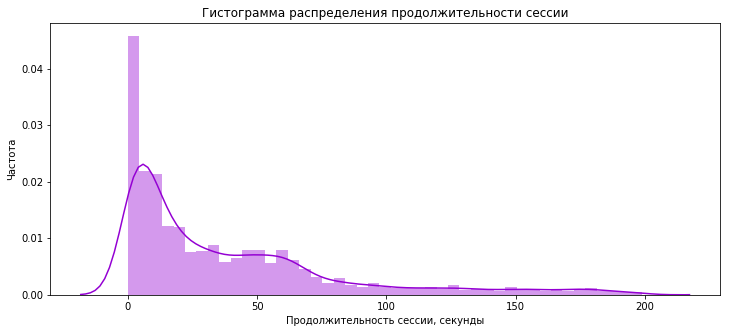

In [277]:
fig, ax = plt.subplots(figsize = (12,5))
sns.distplot(new_features_10users.session_timespan[new_features_10users.session_timespan<200], 
             color = 'darkviolet', axlabel = 'Продолжительность сессии, секунды', ax = ax)
ax.set_title(label  = 'Гистограмма распределения продолжительности сессии')
ax.set_ylabel('Частота')

#### 2.  Гистограмма распределения количества уникальных сайтов в сессии (#unique_sites)

Text(0, 0.5, 'Частота')

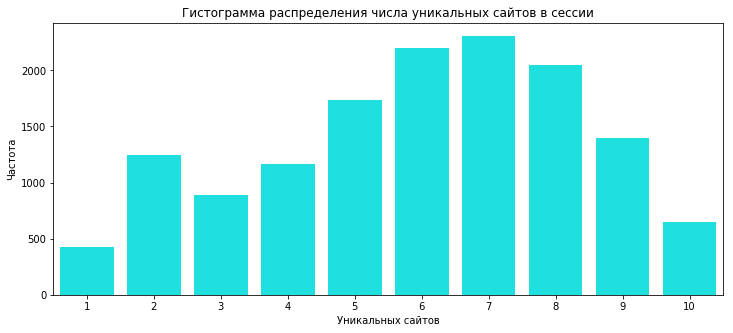

In [278]:
fig, ax = plt.subplots(figsize = (12,5))
sns.countplot(new_features_10users['#unique_sites'], 
             color = 'aqua',ax = ax)
ax.set_title(label  = 'Гистограмма распределения числа уникальных сайтов в сессии')
ax.set_xlabel ('Уникальных сайтов')
ax.set_ylabel('Частота')

#### 3. Гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей

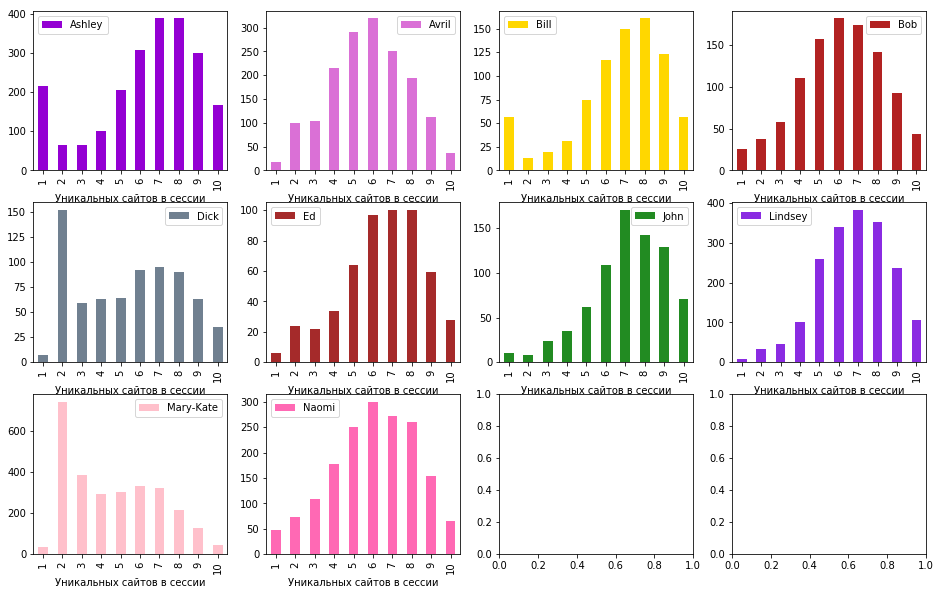

In [279]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
df = train_data_10users[['target','#unique_sites']].groupby('target')

for idx, (user, sub_df) in  enumerate(df):
    ax = axes[idx // 4, idx % 4]
    sub_df['#unique_sites'].value_counts().sort_index().plot(kind='bar', ax=ax, label = user, color = color_dic[user])
    ax.set_xlabel ('Уникальных сайтов в сессии')
    ax.legend()

Можно предположить 3 типа распределения. 1. Близкое к нормальному, смещенное вправо как у Avril, John, Lindsey. 2. С всплеском коротких сессий - Dick, Mary. 3. Комбинация первых двух - Ashley,

#### 4. Гистограмма распределения часа начала сессии

Text(0, 0.5, 'Количество')

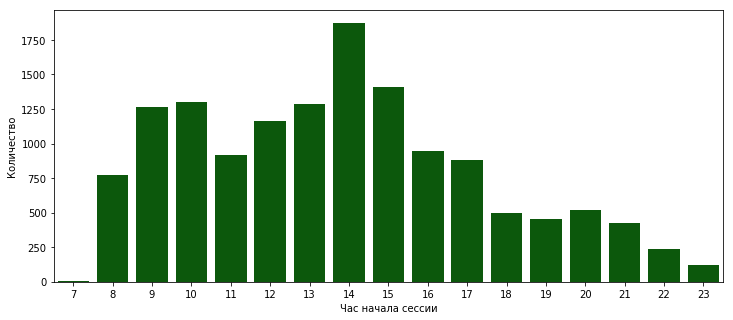

In [280]:
fig, ax = plt.subplots(figsize = (12,5))
sns.countplot(new_features_10users.start_hour, color = 'darkgreen', ax = ax)
ax.set_xlabel('Час начала сессии')
ax.set_ylabel('Количество')

Пользователи активны с 8 часов утра до 23. Можно предположить два пика активности - утром (до 10 часов), днем (до 14 часов).

#### 5. Гистограмма распределения часа начала сессии (start_hour) для каждого из 10 пользователей

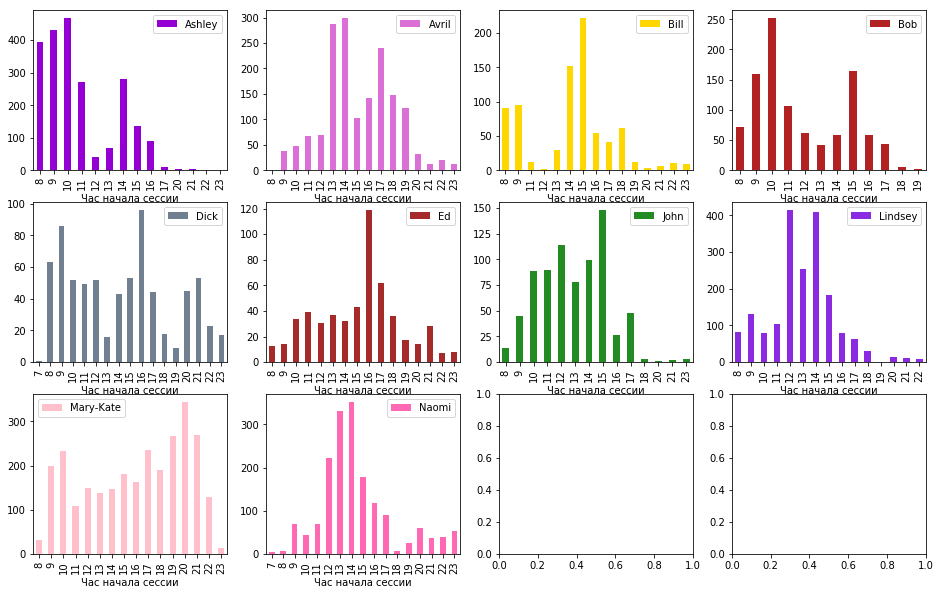

In [281]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
df = train_data_10users[['target','start_hour']].groupby('target')

for idx, (user, sub_df) in  enumerate(df):
    ax = axes[idx // 4, idx % 4]
    sub_df.start_hour.value_counts().sort_index().plot(kind='bar', ax=ax, label = user, color = color_dic[user])
    ax.set_xlabel ('Час начала сессии')
    ax.legend()

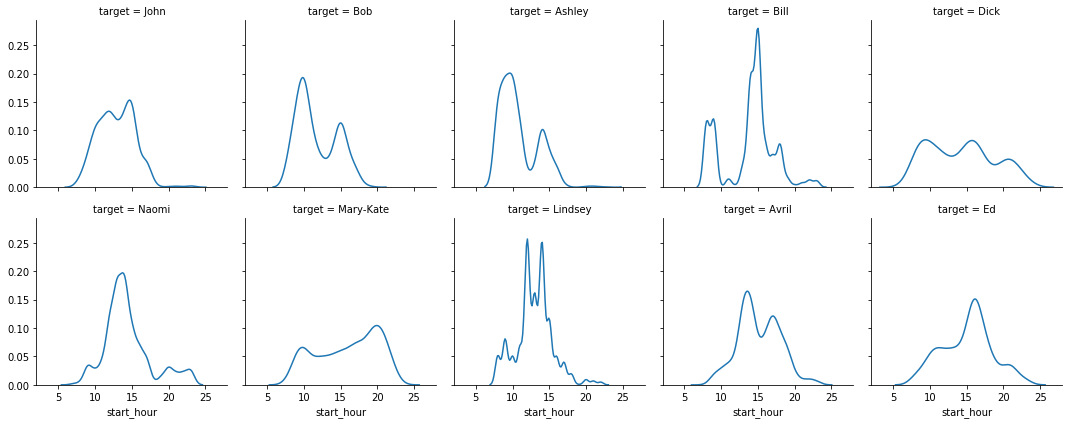

In [282]:
df = train_data_10users[['target','start_hour']]
g = sns.FacetGrid(df, col="target", col_wrap=5)
g.map(sns.kdeplot,'start_hour')

Поведение пользователей различается. 1. Два пика активности - утро и день (Bob, Aschley, Avril, John). 2. Вечер (ночь) - Mary-Kate. 3. День - Ed.
Утро: 6 - 12 часов.
День: 12 - 18 часов.
Вечер: 18 - 23 часов.

#### 6. Гистограмма распределения дня недели, в который началась сессия (day_of_week)

Text(0, 0.5, 'Количество')

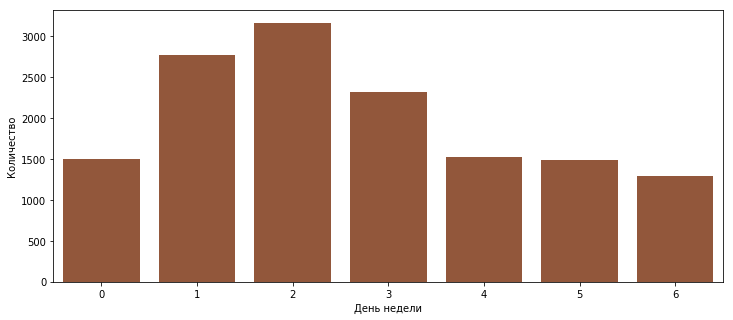

In [283]:
fig, ax = plt.subplots(figsize = (12,5))
sns.countplot(new_features_10users.day_of_week, color = 'sienna', ax = ax)
ax.set_xlabel('День недели')
ax.set_ylabel('Количество')

#### 7. Гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей

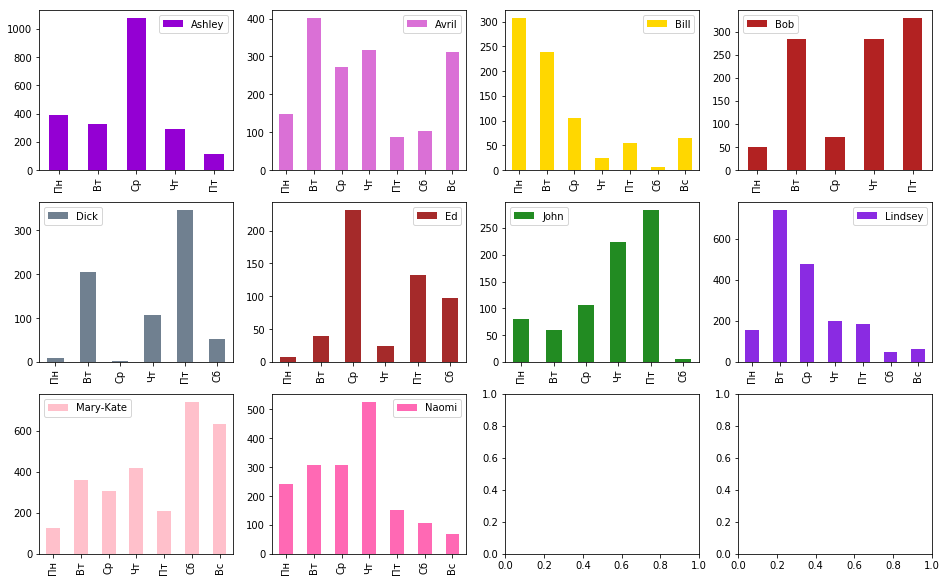

In [284]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
df = train_data_10users[['target','day_of_week']].groupby('target')

for idx, (user, sub_df) in  enumerate(df):
    ax = axes[idx // 4, idx % 4]
    sub_df.day_of_week.value_counts().sort_index().plot(kind='bar', ax=ax, label = user, color = color_dic[user])
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax.legend()

Активность пользователей по дням недели различается. Пользователи активные в выходные - Mary-Kate/Avril и пользователи активные в будни. Можно продублировать категорийным признаком - будний/выходной день.

### 8. Предположения относительно поведения пользователей 

Сведем вместе распределение признаков по каждому пользователю.

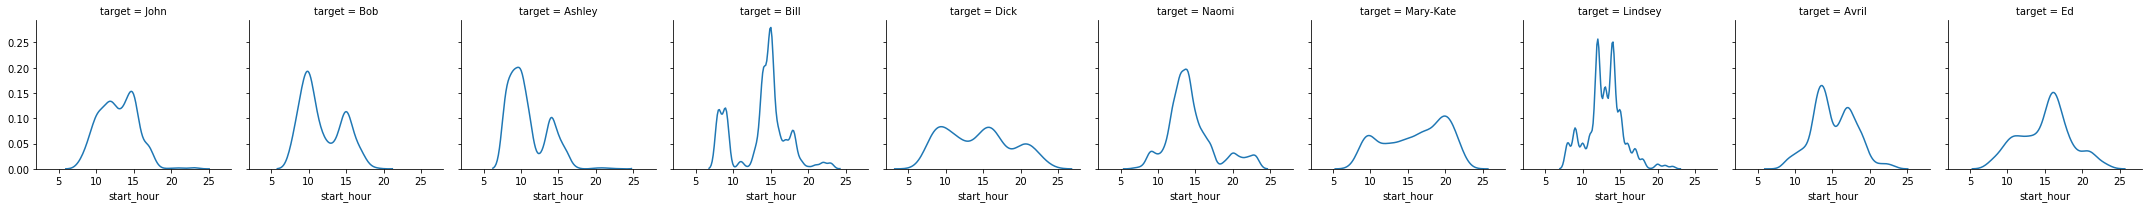

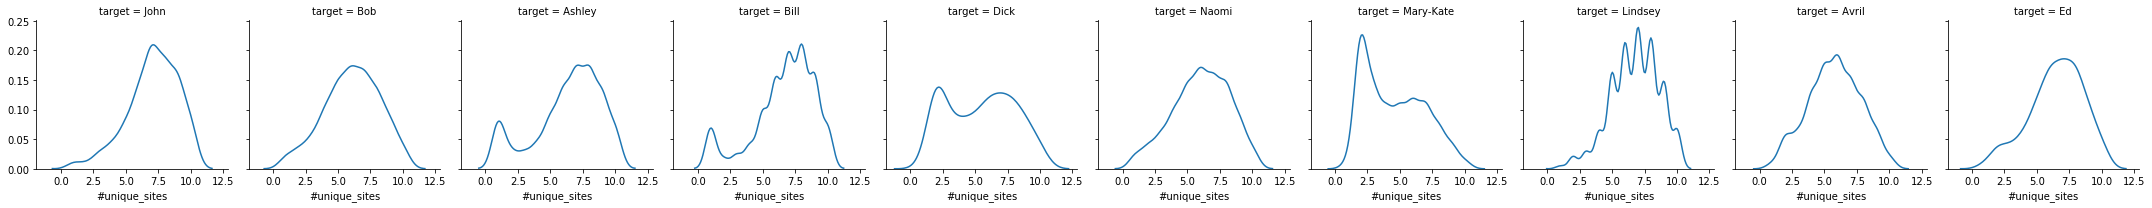

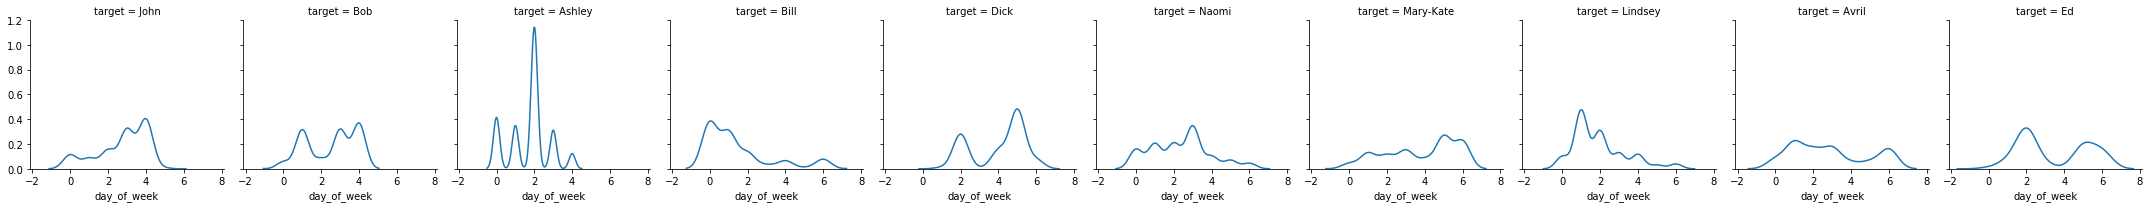

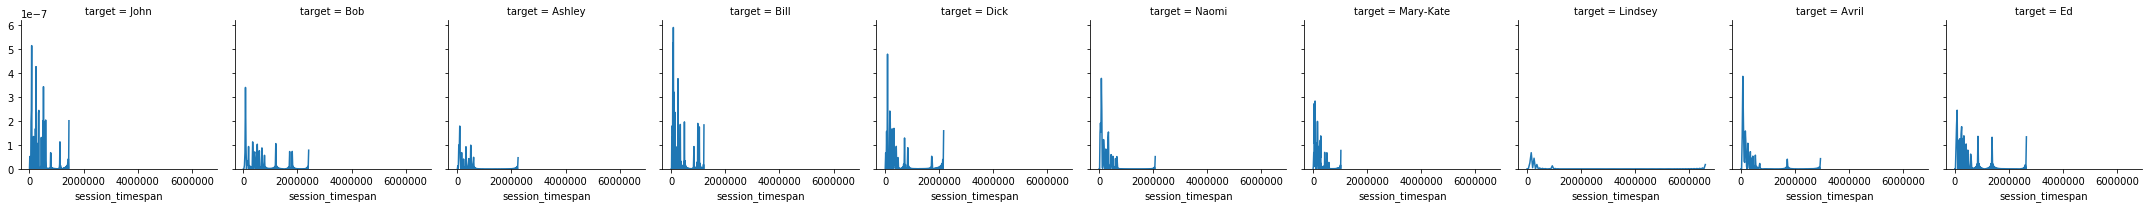

In [285]:
features = ['start_hour','#unique_sites','day_of_week','session_timespan']
df = train_data_10users[['target','start_hour','#unique_sites','day_of_week','session_timespan']]
for f in features:
    g = sns.FacetGrid(df, col="target")
    g.map(sns.kdeplot,f)

#### Отдельно нарисуем признак session_timespan

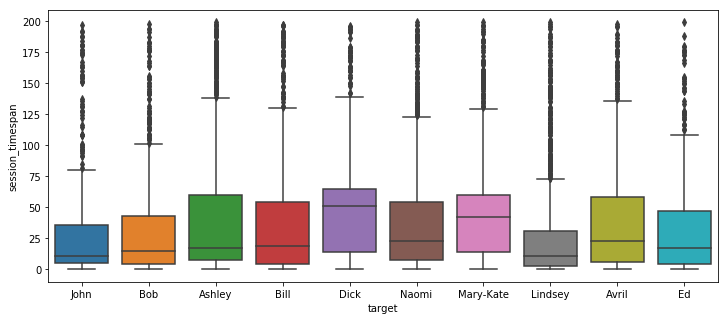

In [286]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(y = 'session_timespan', x = 'target', data= train_data_10users[['session_timespan','target']][train_data_10users['session_timespan']<200], ax = ax)

Медиана и интерквартильный размах у пользователей различаются. В данных много выбросов. Опишем день каждого пользователя по данным:

John
    Приступает к работе в 8 часов, в которой можно наблюдать два пика сессионнной активности - в 12 и достигает максимума в 15 часов. С 18 до 23 часов его активность незначительна. Активность (количество сессий в час) находится на среднем относительно других пользователей уровне. 
    В сессиях немного дублирующих сайтов, чаще всего в сессии присутствует 7 уникальных сайтов.
    В воскресение не работает, его активность по дням недели приходится на будние дни и достигает пика в пятницу.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. При этом медиана и интерквартильный размах находится на уровне Lindsey, меньше чем у остальных.

Bob
    Приступает к работе в 8 часов, в работе наблюдается два пика: максимум - 10, второй - 15 часов. Последняя активность замечена в 19 часов. 
    Активность находится на среднем относительно других пользователей уровне. 
    В сессиях немного дублирующих сайтов, чаще всего в сессии присутствует 6 уникальных сайтов.
    В воскресение не работает, его активность по дням недели приходится на будние дни и достигает пика во вторник и пятницу.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана не превышает 25 сек.
    На timespan графике видно заметное количество сессий продолжительностью более 20 дней.

Ashley
    Приступает к работе в 8 часов, в работе наблюдается два пика: максимум - 10, второй - 14 часов. Далее активность незначительна с 17 часов до 23.
    Активность находится на среднем относительно других пользователей уровне. 
    В сессиях заметно присутствие дублирующих сайтов, чаще всего в сессии присутствует 7/8 уникальных сайтов или 1. Это отличие от других пользователей.
    В воскресение не работает, пик активности приходится на среду.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана не превышает 25 сек.
    На timespan графике видно заметное количество сессий продолжительностью более 20 дней.
    
Bill
    Приступает к работе в 8 часов, в работе наблюдается два пика: максимум - 15, второй - 8-9 часов. В 12 часов - перерыв. Далее активность незначительна с 19 часов до 23.
    Активность выше относительно других пользователей. 
    В сессиях заметно присутствие дублирующих сайтов, чаще всего в сессии присутствует 8/9 уникальных сайтов, есть пик со значением 1. 
    В воскресение работает, пик активности приходится на понедельник.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана не превышает 25 сек.
    
Dick
    Приступает к работе в 7 часов, в работе наблюдается три неявных пика: максимум - 16, второй - 9 часов, третий - 21 час.
    Активность ниже относительно других пользователей. 
    В сессиях заметно присутствие дублирующих сайтов, чаще всего в сессии присутствует 2 уникальных сайта. 
    В воскресение не работает, пик активности приходится на пятницу.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана превышает 50 сек (отличие).
    На timespan графике видно заметное количество сессий продолжительностью более 20 дней.
    
Naomi
    Приступает к работе в 7 часов, в работе наблюдается пики активности: дневной с максимумом 14 часов и вечерний с 19 до 23.
    Активность на уровне  других пользователей. 
    Уникальные сайты распределены колоколообразно, чаще всего в сессии присутствует 6 уникальных сайта. 
    В воскресение  работает, пик активности приходится на четверг.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана на уровне 25 сек.
    
Mary-Kate
    Приступает к работе в 8 часов, в работе наблюдается пики активности: дневной с максимумом 10 часов и вечерний  - 20. Сдвиг в вечернее время относительно других пользователей. 
    Активность на уровне  других пользователей. 
    Уникальные сайты в сессии немного,  чаще всего в сессии присутствует 2 уникальных сайта. 
    В воскресение работает, пик активности приходится на выходные - суббота и воскресение.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана на уровне 50 сек.
    
Lindsey
    Приступает к работе в 8 часов, в работе наблюдается нехарактерные пики активности: 12 и 14 часов. В вечернее время активность незначительна.
    Активность выше уровня  других пользователей. 
    Уникальные сайты распределены колоколообразно, чаще всего в сессии присутствует 7 уникальных сайтов. 
    В воскресение работает, пик активности приходится на вторник.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана ниже 25 сек, размах минимален среди пользователей. 

Avril
    Приступает к работе в 8 часов, в работе наблюдается пик активности: 14 и 17 часов. В вечернее время активность незначительна.
    Активность на уровне  других пользователей. 
    Уникальные сайты распределены колоколообразно, чаще всего в сессии присутствует 6 уникальных сайтов. 
    В воскресение работает,  активность на уровне будних дней.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана на уровне 25 сек.
    
Ed
    Приступает к работе в 8 часов, в работе наблюдается пик активности: 16 часов. В вечернее время активность в 21 час.
    Активность на уровне  других пользователей. 
    Уникальные сайты распределены колоколообразно, чаще всего в сессии присутствует 6-8 уникальных сайтов. 
    В воскресение не работает,  пик активности приходится на среду.
    В продолжительности сессий много выбросов, впрочем как и у остальных пользователей. Медиана ниже 25 сек.
    
У пользователей различаются количество пиков активностей и их значения относительно часа дня и дня недели.
Можно выделить группы пользователей с различными значениями медианных значений продолжительности сессиий. Выбросы значительны и могут достигать значений 70 дней. Похоже, что пользователь может прервать сессию и возобновить ее через несколько дней и даже месяцев. Каникулы? Можно отразить время начала сессии в днях года (месяцах) для визуализации активности в пределах года.

#### 9. Наиболее посещаемые сайты

In [287]:
site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')

with open (site_freq_path, 'rb') as f:
    dict_ = pickle.load(f)
    
list(dict_.items())[0:10]

[('s.youtube.com', (1, 8300)),
 ('www.google.fr', (2, 7813)),
 ('www.google.com', (3, 5441)),
 ('mail.google.com', (4, 4158)),
 ('www.facebook.com', (5, 4141)),
 ('apis.google.com', (6, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (7, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (8, 3094)),
 ('plus.google.com', (9, 2630)),
 ('accounts.google.com', (10, 2089))]

In [288]:
top10_sites = list(dict_.keys())[:10]
top10_freq = [dict_[k][1] for k in top10_sites] 

In [289]:
top30_sites = list(dict_.keys())[:30]
top30_freq = [dict_[k][1] for k in top10_sites] 

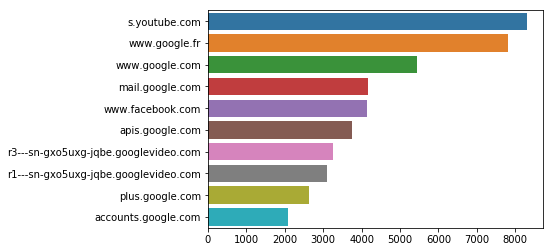

In [290]:
sns.barplot(top10_freq, top10_sites)

Text(0.5, 1.0, 'Наиболее посещаемые сайты')

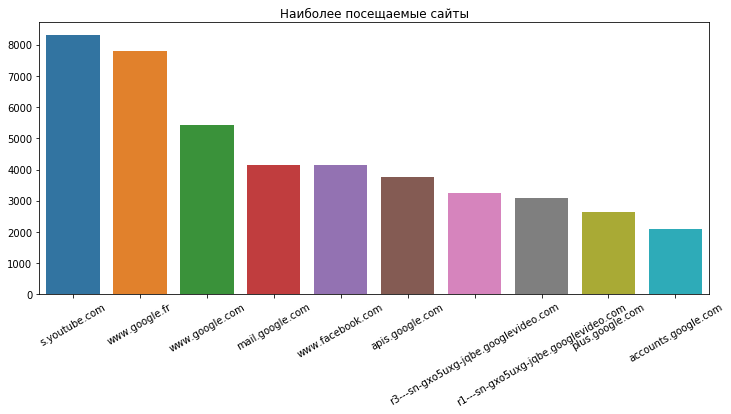

In [291]:
fig, ax = plt.subplots(figsize = (12,5))
sns.barplot(top10_sites, top10_freq, ax = ax)
plt.xticks(rotation = 30)
ax.set_title ('Наиболее посещаемые сайты')

В топ-10 популярных сайтов находятся сервисы google и facebook. В топ-30 к ним присоединится почта yahoo и twitter. 

## III. Генерация дополнительных признаков

Модифицирую предыдущую функцию:

In [292]:
def feature_engineering (path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' return new df with engineered features  '''
    
    #загрузка файлов в df для последующей обработки
    df = load_train_set(path_to_csv_files)
    
    # замена имен сайтов на id из частотного словаря
    with open (site_freq_path, 'rb') as f:
        dict_ = pickle.load(f)
    dict_[0]= (0,0)
    df.site = df.site.apply(lambda x: dict_[x][0])
    
    # генерация сессий скользящими окнами по сайту и времени его посещения
    site_frame_ = [] #список фреймов сайтов
    time_frame_ = [] #список фреймов таймштампов
    time_diff_ = [] # список фреймов разности соседних таймштампов
    target = []

    for user in tqdm (df.user_id.unique()):
        site_log = df[df['user_id']== user].site
        site_frame_.append (pd.DataFrame ([site_log[sp:sp+session_length].values for sp in range(0,site_log.shape[0],window_size)]))
    
        time_log = df[df['user_id']== user].time_start
        t = pd.DataFrame ([time_log[sp:sp+session_length].values for sp in range(0,time_log.shape[0],window_size)])
    
        time_frame_.append (t) 
        time_diff_.append((t - t.shift(axis=1)).applymap(lambda x: x.seconds).fillna(0).astype(int).drop(columns = [0])) # 
    
        target.extend ([user]*t.shape[0]) #восстановим столбец разметки для  размерности нового df
    
    # создание fe по заданию
    site_frame = (pd.concat(site_frame_, ignore_index=True)).fillna(0).astype(int)
    time_frame = (pd.concat(time_frame_, ignore_index=True))
    time_diff = (pd.concat(time_diff_, ignore_index=True)).fillna(0).astype(int)
        
    new_df = pd.concat((site_frame,time_diff), axis = 1)
    new_df['session_timespan'] = time_frame.apply(lambda x: (x.max() - x.min()).total_seconds(), axis = 1).astype(int)
    new_df['#unique_sites'] = site_frame[site_frame > 0].progress_apply(lambda x: x.dropna().unique().shape[0], axis = 1).astype(int) #быстрее, чем условие [x>0]
    new_df['start_hour'] = time_frame.apply(lambda x: x.min().hour, axis = 1).astype(int)
    new_df['day_of_week'] = time_frame.apply(lambda x: x.min().weekday(), axis = 1).astype(int)
    new_df['target']=pd.DataFrame(target).astype (int)
    new_df.columns = feature_names  
    
    #экспериментальные признаки
    new_df['ts_median'] = time_diff.apply(lambda x: x.median(), axis = 1).astype(int) # медианное время между доступом к сайту в сессии
    new_df['ts_var'] = time_diff.apply(lambda x: x.std(), axis = 1) # отклонение среднего времени нахождения на сайте
    new_df['ts_short'] = time_diff.apply(lambda x: x[x<3].count(), axis=1) # количество коротких просмотров в сессии
    new_df['ts_short/unique'] = new_df['ts_short']/new_df['#unique_sites'] # доля коротких просмотров в сессии к уникальным сайтам
    new_df['ts_is_morning'] = new_df['start_hour'].apply(lambda x: 1 if (x>=6 and x<12) else 0) #dummy признаки времени суток
    new_df['ts_is_day'] = new_df['start_hour'].apply(lambda x:  1 if (x>=12 and x<18) else 0)
    new_df['ts_is_evening'] = new_df['start_hour'].apply(lambda x: 1 if (x>=18 and x<22) else 0)
    new_df['ts_is_late']  =  new_df['start_hour'].apply(lambda x: 1 if (x>=22 and x<24) else 0)
    new_df['ts_is_weekend'] = new_df['day_of_week'].apply(lambda x: 1 if (x>4 and x<7) else 0) #признак выходного
    new_df['site_top_count'] = site_frame.apply (lambda x: len (x[x<50].unique()), axis = 1)  #количество топ-50 уникальных популярных сайтов в сессии
    new_df['site_top_count/unique'] = new_df['site_top_count']/new_df['#unique_sites'] #доля популярных сайтов в сессии
    new_df['ts_dayofyear'] = time_frame.apply(lambda x: x.min().dayofyear, axis = 1).astype(int)
    new_df['ts_month'] = time_frame.apply(lambda x: x.min().month, axis = 1).astype(int)
    
    return new_df

In [293]:
PATH_TO_DATA = 'capstone_user_identification'
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy_fe = feature_engineering(os.path.join(PATH_TO_DATA,'3users'),
                                     site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                                     feature_names = feature_names, session_length=10)

In [294]:
train_data_toy_fe

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      3      2      2      7      2      1      8      5      9      10   
1      3      1      1      1      0      0      0      0      0       0   
2      3      2      6      6      2      0      0      0      0       0   
3      4      1      2      1      2      1      1      5     11       4   
4      4      1      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  ...  #unique_sites  start_hour  day_of_week  target  ts_median  \
0           2  ...              8           9            4       1         55   
1           0  ...              2          12            4       1          0   
2           0  ...              3           9            4       2          0   
3           2  ...              5           9            4       3         55   
4           0  ...              3          12            4       3          0   

        ts_var  ts_short  ts_short/unique  ts_is_morning  ts_is_day  \
0  2056.319285         3         0.375000              1          0   
1    18.159020         7         3.500000              0          1   
2  2059.614042         5         1.666667              1          0   
3  2056.319285         3         0.600000              1          0   
4   394.302901         7         2.333333              0          1   

   ts_is_evening  ts_is_late  ts_is_weekend  site_top_count  \
0              0           0              0               8   
1              0           0              0               3   
2              0           0              0               4   
3              0           0              0               5   
4              0           0              0               4   

   site_top_count/unique  ts_dayofyear  ts_month  
0               1.000000           319        11  
1               1.500000           319        11  
2               1.333333           319        11  
3               1.000000           319        11  
4               1.333333           319        11  

[5 rows x 37 columns]

#### 1. Обработка данных по 10 пользователям

In [295]:
PATH_TO_DATA = 'capstone_user_identification'

train_data_10users_fe = feature_engineering(os.path.join(PATH_TO_DATA,'10users'),
                                     site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                                     feature_names = feature_names, session_length=10)

In [296]:
train_data_10users_fe.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    574    133      3    133    133      3    133    203     133   
1    415    193    674    254    133     31    393   3305    217      55   
2     55      3     55     55      5    293    415    333    897      55   
3    473   3306    473     55     55     55     55    937    199     123   
4    342     55      5   3307    258    211   3308   2086    675    2086   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  ...  #unique_sites  start_hour  day_of_week  target  ts_median  \
0           0  ...              5           8            4      31          1   
1           3  ...             10           8            4      31          3   
2           1  ...              7           8            4      31          0   
3           0  ...              6           8            4      31          1   
4           1  ...              9           8            4      31          1   

      ts_var  ts_short  ts_short/unique  ts_is_morning  ts_is_day  \
0   6.910137         7         1.400000              1          0   
1  59.912668         4         0.400000              1          0   
2  80.129583         7         1.000000              1          0   
3   8.154753         8         1.333333              1          0   
4   0.500000         9         1.000000              1          0   

   ts_is_evening  ts_is_late  ts_is_weekend  site_top_count  \
0              0           0              0               1   
1              0           0              0               1   
2              0           0              0               2   
3              0           0              0               0   
4              0           0              0               1   

   site_top_count/unique  ts_dayofyear  ts_month  
0               0.200000           319        11  
1               0.100000           319        11  
2               0.285714           319        11  
3               0.000000           319        11  
4               0.111111           319        11  

[5 rows x 37 columns]

In [316]:
train_data_150users_fe = feature_engineering(os.path.join(PATH_TO_DATA,'150users'),
                                     site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                                     feature_names = feature_names, session_length=10)

### 2. Корреляция и вариация новых признаков

In [297]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users_fe['target'] = train_data_10users_fe['target'].map(id_name_dict)

In [298]:
fe_features = ['session_timespan','#unique_sites','start_hour', 'day_of_week', 'ts_median', 'ts_var','ts_short', 'site_top_count', 'ts_dayofyear', 'ts_month', 'ts_short/unique',
              'site_top_count/unique']
fe_df = train_data_10users_fe[fe_features+['target']]
fe_df.corr()

session_timespan  #unique_sites  start_hour  \
session_timespan               1.000000       0.022519    0.025345   
#unique_sites                  0.022519       1.000000   -0.123277   
start_hour                     0.025345      -0.123277    1.000000   
day_of_week                   -0.005698      -0.224307    0.221487   
ts_median                      0.380406      -0.094181    0.073211   
ts_var                         0.494661       0.044479    0.083623   
ts_short                      -0.056554       0.464575   -0.164184   
site_top_count                 0.018255       0.370500    0.022583   
ts_dayofyear                   0.015863       0.051702   -0.029530   
ts_month                       0.014312       0.042642   -0.020095   
ts_short/unique               -0.038251      -0.409952   -0.123482   
site_top_count/unique         -0.006462      -0.394421    0.136885   

                       day_of_week  ts_median    ts_var  ts_short  \
session_timespan         -0.005698   0.380406  0.494661 -0.056554   
#unique_sites            -0.224307  -0.094181  0.044479  0.464575   
start_hour                0.221487   0.073211  0.083623 -0.164184   
day_of_week               1.000000   0.051808 -0.004948 -0.182675   
ts_median                 0.051808   1.000000  0.119292 -0.258935   
ts_var                   -0.004948   0.119292  1.000000 -0.107718   
ts_short                 -0.182675  -0.258935 -0.107718  1.000000   
site_top_count            0.033975   0.002060  0.063993  0.056461   
ts_dayofyear             -0.038908  -0.007758  0.040661  0.061938   
ts_month                 -0.034576  -0.008059  0.038367  0.057259   
ts_short/unique          -0.023503  -0.103706 -0.072923  0.355670   
site_top_count/unique     0.247230   0.074944  0.013541 -0.328897   

                       site_top_count  ts_dayofyear  ts_month  \
session_timespan             0.018255      0.015863  0.014312   
#unique_sites                0.370500      0.051702  0.042642   
start_hour                   0.022583     -0.029530 -0.020095   
day_of_week                  0.033975     -0.038908 -0.034576   
ts_median                    0.002060     -0.007758 -0.008059   
ts_var                       0.063993      0.040661  0.038367   
ts_short                     0.056461      0.061938  0.057259   
site_top_count               1.000000     -0.002809 -0.004637   
ts_dayofyear                -0.002809      1.000000  0.997768   
ts_month                    -0.004637      0.997768  1.000000   
ts_short/unique             -0.244224     -0.018094 -0.017945   
site_top_count/unique        0.620995     -0.069202 -0.061622   

                       ts_short/unique  site_top_count/unique  
session_timespan             -0.038251              -0.006462  
#unique_sites                -0.409952              -0.394421  
start_hour                   -0.123482               0.136885  
day_of_week                  -0.023503               0.247230  
ts_median                    -0.103706               0.074944  
ts_var                       -0.072923               0.013541  
ts_short                      0.355670              -0.328897  
site_top_count               -0.244224               0.620995  
ts_dayofyear                 -0.018094              -0.069202  
ts_month                     -0.017945              -0.061622  
ts_short/unique               1.000000               0.080208  
site_top_count/unique         0.080208               1.000000

В признаках есть ожидаемая корреляция между днем года и месяцем, средняя корреляция между #unique и ts_short/unique. Признак ts_month пока исключим из рассмотрения.

In [299]:
fe_features = ['ts_median', 'ts_var','ts_short','site_top_count/unique', 'ts_dayofyear']
fe_df = train_data_10users_fe[fe_features+['target']]
var_df = pd.concat((fe_df.median(),fe_df.std()), axis = 1, keys =  ['median','variance'])[:-1]
var_df

median     variance
ts_median              1.000000    40.717314
ts_var                 4.769696  3398.504404
ts_short               6.000000     2.571742
site_top_count/unique  0.555556     0.323522

Новые признаки имеют значительную дисперсию, вомзожно, содержат информацию.

### 3.Визуальный анализ распределения новых признаков

#### 1. Признак дня года

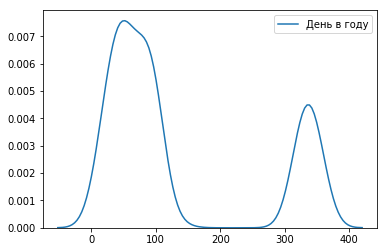

In [300]:
# восстановим распределение частот сессий по дню года
sns.kdeplot(fe_df['ts_dayofyear'], label = 'День в году')

Вывод. Предположение о том, что активность пользователей имеет пики по году подтвердилось. Очевидно, дело в каникулах.

#### 2. Распределение признаков по пользователю

Построим сетку по полученным признакам и посмотрим, что получится:

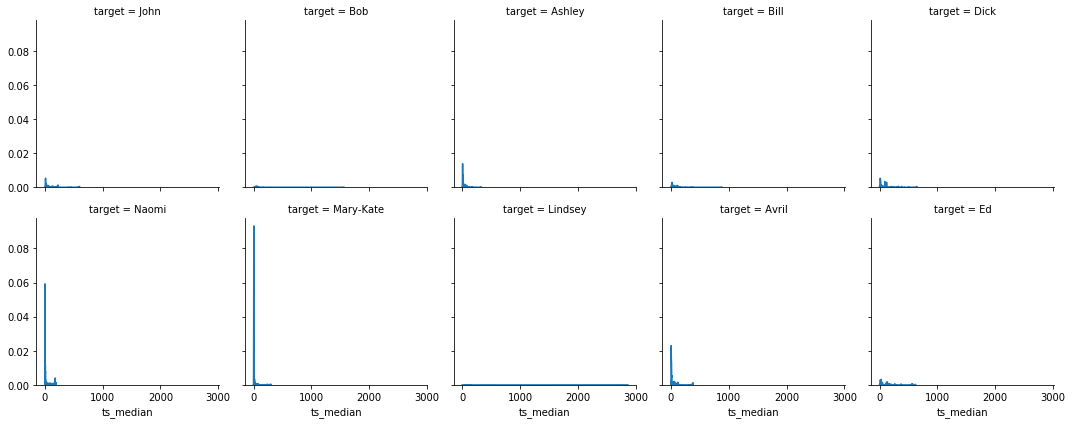

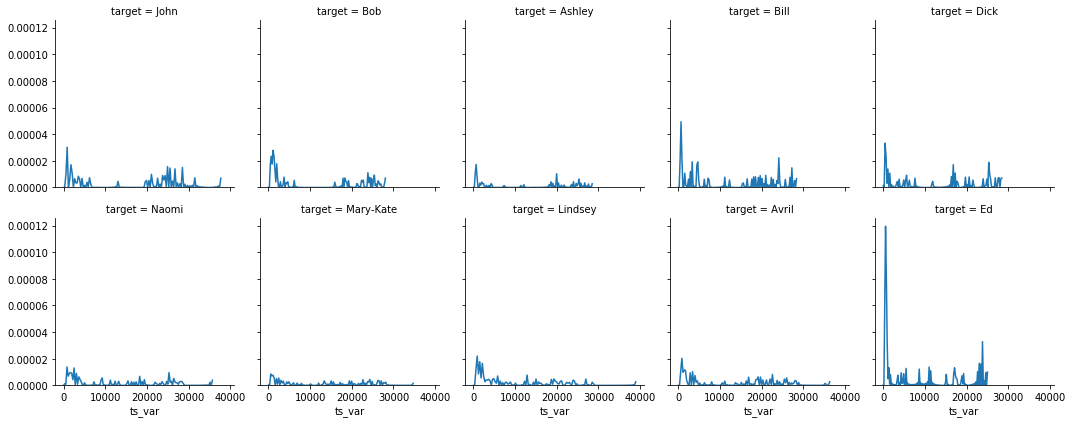

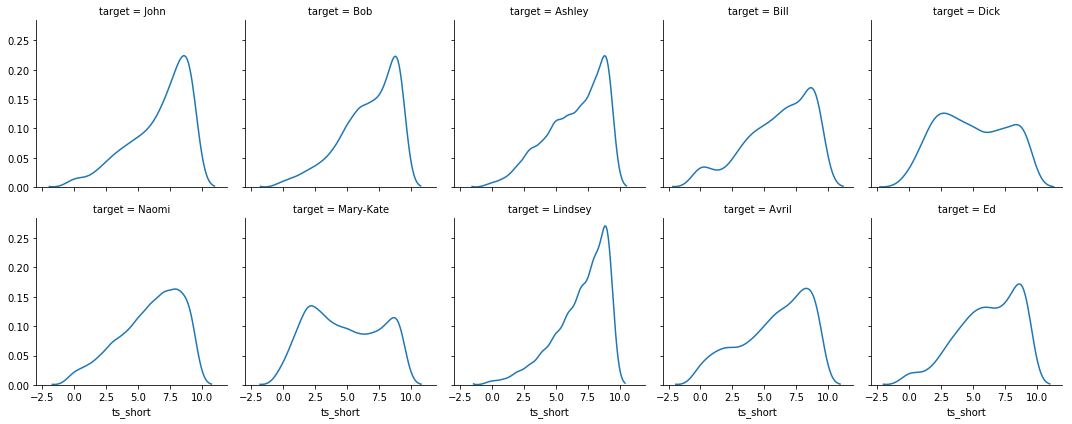

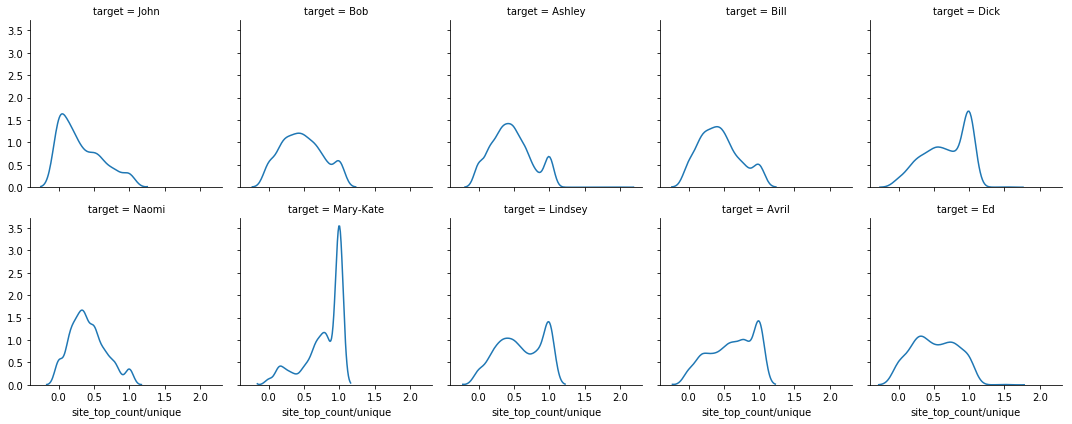

In [301]:
for f in fe_features:
    g = sns.FacetGrid(fe_df, col="target", col_wrap = 5)
    g.map(sns.kdeplot,f)

- Распределение медианного времени сессии (ts_median) по - прежнему имеет тяжелый хвост и его визуализация малоинформативна. Попробуем грубо очистить выборку от выбросов, убрав все значения превышающие интерквартильный размах (ниже). Восстановленные распределения пользователей показывают, что у двоих (Mary_Kate и Dick) распределение отличается от прочих. 

In [303]:
for target in fe_df['target'].unique():
    sns.kdeplot(fe_df[(fe_df.target==target) & (fe_df.ts_median<5)].ts_median, label = target)

- Распределение вариации (ts_var) - малоинформативно, но можно заметить, что кривая отличается у Bill и Ed.
- Распределение коротких сессий (ts_short) - можно выделить 3 шаблона. Примеры: 1 -Lindsey. 2 - John, Bob, Ed. 3 - Mary_Kate.
- Распределение популярных сайтов в сессии (site_top_count/unique) - можно выделить 3 шаблона. Сдвиг влево (мало популярных сайтов) - John, Bill, Ed. Сдвиг вправо (много) - Dick, Avril. Lindsey. Аномалия - Mary_Kate.
- Распределения по дням года (ts_dayofyear). Пользователи одинаково активные в начале и конце года (John, bob, Ed). Активные в конце года - Bill. Активные в начале - Naomi/Avril.
Аномалия - Mary_Kate, Dick.

#### 3.Попарная визуализация

Попробуем на глаз оценить зависимость между признаками. Построим сетку:

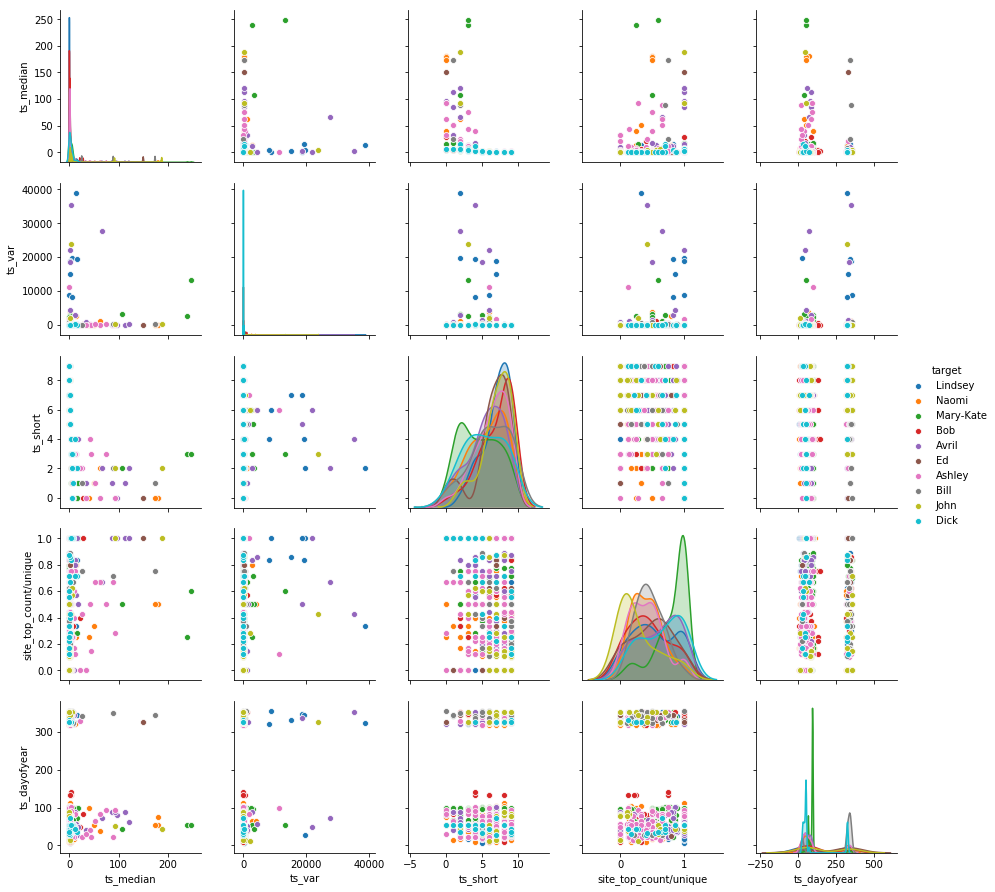

In [257]:
#новые признаки, берем sample, чтобы избежать оверплоттинга
sns.pairplot(fe_df.sample(700), hue = 'target')

Убедительного разделения классов нет ни на одной картинке, но есть ощущение, что на некоторых картинках группировка есть. Например, в признаке ts_median. Уберем выбросы - продолжительные сессии.

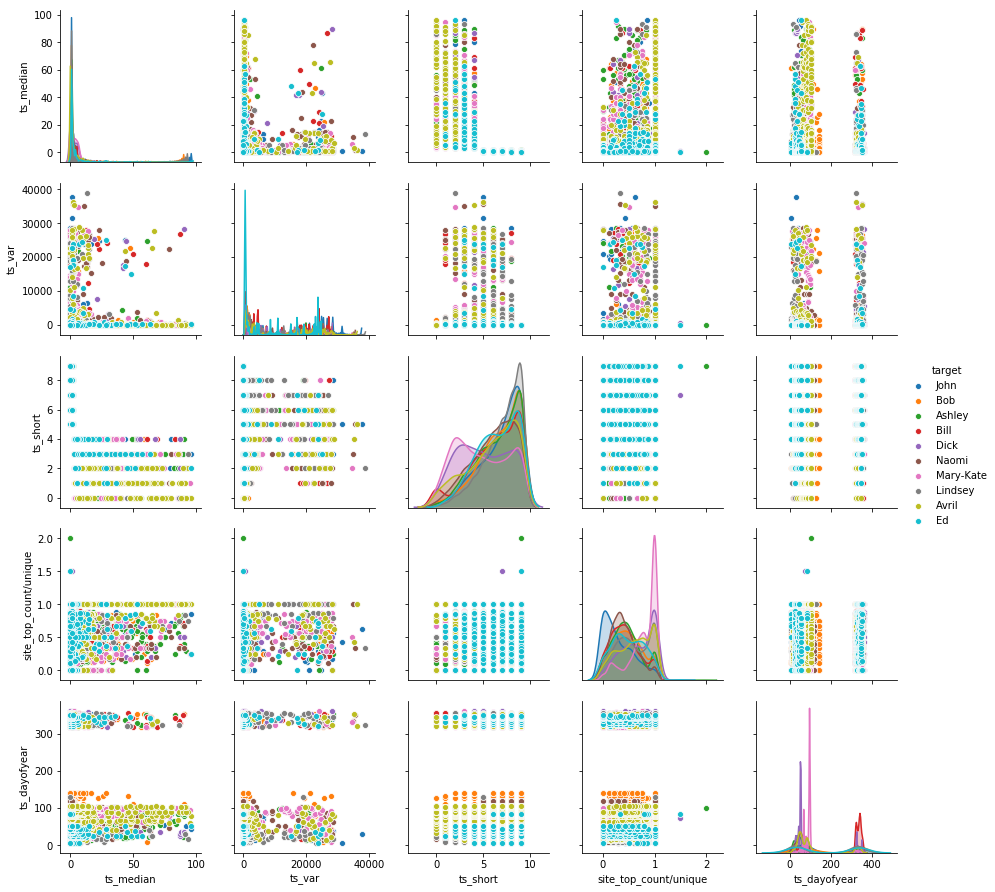

In [304]:
#уберем выбросы длин сессий
sns.pairplot(fe_df [fe_df.ts_median<100], hue = 'target')

Данные визуально стали лучше разделяться по признакам:
    - ts_median/ts_short
    - ts_median/ts_day_of_year
    - ts_median/site_top_count
    - ts_short/site_top_count

Ради любопытства смешаем на сетке признаки пункта 2 и пункта 3:

In [259]:
#комбинация признаков пункта 2 и пункта 3
fe_df2 = train_data_10users_fe[fe_features+['target']+['start_hour']+['#unique_sites']]

In [260]:
sns.pairplot(fe_df2.sample(1000), hue = 'target')

Пара start_hour/ts_short. Возможно есть зависимость нелинейная.
Итого: интерес вызывали признаки start_hour/ts_dayofyear/ts_short/site_top_count/ts_median.
Но поскольку визуальный анализ не дает убедительного ответа о влиянии признаков, то сохраню все полученные признаки, кроме ts_month.

In [320]:
selected_features_10users = train_data_10users_fe.iloc[:,:-1]
selected_features_150users = train_data_150users_fe.iloc[:,:-1]

In [321]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)